<a href="https://colab.research.google.com/github/Pumafi/dl_spatial_gen_geol_facies/blob/main/wgan2d_gs_horizontal_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wasserstein GAN with Spectral Norm and MaxSort Activation (WGAN-GS)
(source paper : https://proceedings.mlr.press/v97/anil19a.html)

In [1]:
!python3 -m pip install deel.lip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 512.7 kB/s eta 0:00:00


In [2]:
!python3 -m pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.3 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import image

from keras import backend as K
from keras import initializers
from keras.layers import Dense, Conv2D, InputSpec

import matplotlib.pyplot as plt

from deel.lip.activations import GroupSort
from deel.lip.layers import (
    InvertibleDownSampling,
)
import tensorflow_addons as tfa

from keras import layers

import math
import tensorflow_datasets as tfds
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:

class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v

        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output


class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)

        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            # Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v

        # Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)

        outputs = K.conv2d(
            inputs,
            W_bar,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [5]:


def maxsort(x):
    return GroupSort(2)(x)


class StationaryWasserteinApprox(tf.keras.layers.Layer):
    def __init__(self):
        super(StationaryWasserteinApprox, self).__init__()
        self.conv = ConvSN2D(filters=1, kernel_size=(3, 3), strides=(1, 1), padding='valid')

    def call(self, x):
        y = self.conv(x)
        y = tf.math.reduce_mean(y)
        return y


class InitialDiscriminatorBlock(tf.keras.layers.Layer):
    def __init__(self, features, kernel_size=(3, 3), avg_pooling=(2, 2), padding="same", name="initial-disc-block"):
        super(InitialDiscriminatorBlock, self).__init__()

        self.conv_1 = ConvSN2D(filters=features, kernel_size=kernel_size,
                               strides=(1, 1), padding=padding,
                               activation=maxsort,
                               name=name + "-conv1")

        self.conv_2 = ConvSN2D(filters=features, kernel_size=kernel_size,
                               strides=(1, 1), padding=padding,
                               activation=maxsort,
                               name=name + "-conv2")

        self.avg_pool = InvertibleDownSampling(pool_size=avg_pooling, name=name + "-avg-pool")

    def call(self, inputs):
        y = self.conv_1(inputs)
        y = self.conv_2(y)
        y = self.avg_pool(y)

        return y


class DiscriminatorBlock(tf.keras.layers.Layer):
    def __init__(self, features, kernel_size=(3, 3), avg_pooling=(2, 2), padding="same", name="inter-disc-block"):
        super(DiscriminatorBlock, self).__init__()

        self.conv_1 = ConvSN2D(filters=features, kernel_size=kernel_size,
                               strides=(1, 1), padding=padding,
                               activation=maxsort,
                               name=name + "-conv1")

        self.conv_2 = ConvSN2D(filters=features, kernel_size=kernel_size,
                               strides=(1, 1), padding=padding,
                               activation=maxsort,
                               name=name + "-conv2")

        self.avg_pool = InvertibleDownSampling(pool_size=avg_pooling, name=name + "-avg-pool")

    def call(self, inputs):
        y = self.conv_1(inputs)
        y = self.conv_2(y)
        y = self.avg_pool(y)

        return y


class FinalDiscriminatorBlock(tf.keras.layers.Layer):
    def __init__(self, features, kernel_size_1=(3, 3), kernel_size_2=(3, 3), padding="same", name="final-disc-block"):
        super(FinalDiscriminatorBlock, self).__init__()

        self.conv_1 = ConvSN2D(filters=features, kernel_size=kernel_size_1,
                               strides=(1, 1), padding=padding,
                               activation=maxsort,
                               name=name + "-conv1")

        self.conv_2 = ConvSN2D(filters=features, kernel_size=kernel_size_2,
                               strides=(1, 1), padding=padding,
                               activation=maxsort,
                               name=name + "-conv2")

        self.dense = tf.keras.layers.Dense(1, name="disc-dense-output", activation=None)

    def call(self, inputs):
        y = self.conv_1(inputs)
        y = self.conv_2(y)
        y = self.dense(y)

        return y


def get_wgs_discriminator_model(input_dims, kernel_size=(3, 3), layers_features=None):
    if layers_features is None:
        layers_features = [16, 32, 64, 128, 256]

    padding = "same"

    x_high_res = tf.keras.layers.Input(shape=(input_dims[0], input_dims[1], input_dims[2]))

    y = InitialDiscriminatorBlock(layers_features[0], kernel_size=kernel_size)(x_high_res)
    y = DiscriminatorBlock(layers_features[1], kernel_size=kernel_size, padding=padding, name="disc-block-1")(y)
    y = DiscriminatorBlock(layers_features[2], kernel_size=kernel_size, padding=padding, name="disc-block-2")(y)
    y = DiscriminatorBlock(layers_features[3], kernel_size=kernel_size, padding=padding, avg_pooling=(1, 1),
                           name="disc-block-3")(y)
    y = FinalDiscriminatorBlock(layers_features[4], kernel_size_1=kernel_size, padding=padding)(y)

    d_model = keras.models.Model(x_high_res, y, name="discriminator")
    return d_model

In [6]:
import tensorflow as tf

class GeneratorInitial(tf.keras.layers.Layer):
    # First layer of the Multi-Scale Generator
    # It is a simple convolution, but without skip connection, 256 channels and a large kernel size
    def __init__(self, features=4, kernel_size=(3, 3), padding="valid"):
        super(GeneratorInitial, self).__init__()
        self.batch_norm = tf.keras.layers.BatchNormalization(momentum=0.9)
        self.conv = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                           strides=(1, 1), activation="relu", padding=padding, name="gen-init-conv")

    def call(self, inputs):
        y = self.conv(inputs)
        y = self.batch_norm(y)

        return y


class GeneratorBlock(tf.keras.layers.Layer):
    # Intermediate layers of the Multi-Scale Generator
    # This block has: One upsampling layer, two convolutions,
    # one skip connections and a Batch Normalisation
    def __init__(self, features, output_features, upsampling_size=(1, 1), kernel_size=(3, 3), padding="valid",
                 name="gen-block"):
        super(GeneratorBlock, self).__init__()
        self.upsample = tf.keras.layers.UpSampling2D(size=upsampling_size,
                                                     interpolation='nearest',
                                                     name=name + "-upsampling")

        self.conv_1 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv1")

        self.conv_2 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv2")
        self.batch_norm = tf.keras.layers.BatchNormalization(momentum=0.9)

    def call(self, inputs):
        y = self.upsample(inputs)
        y = self.conv_1(y)
        y = self.batch_norm(y)
        y = self.conv_2(y)

        return y


class LastGeneratorBlock(tf.keras.layers.Layer):
    # Last block of the Multi-Scale Generator model
    # Same as intermediate blocks but without skip connections
    # The resizing method is also changed to bilinear for a smoother result
    def __init__(self, features, output_features, kernel_size=(3, 3), upsampling=(1, 1), padding="valid",
                 name="gen-fin-block"):
        super(LastGeneratorBlock, self).__init__()
        self.upsample = tf.keras.layers.UpSampling2D(size=upsampling,
                                                     interpolation='bilinear',
                                                     name=name + "-upsampling")

        self.conv_1 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv1")

        self.conv_2 = tf.keras.layers.Conv2D(filters=output_features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding, activation=None,
                                             name=name + "-final-conv")
        self.batch_norm = tf.keras.layers.BatchNormalization(momentum=0.9)

    def call(self, inputs):
        # Conv
        y = self.upsample(inputs)
        y = self.conv_1(y)
        y = self.batch_norm(y)
        y = self.conv_2(y)

        return y


class WassersteinGSGenerator(tf.keras.Model):
    def __init__(self, output_dims, kernel_size=(3, 3), layers_features=None):
        """
        Generator class for Multi-Scale model
        Args:
            output_dims: tuple (h, w, c) giving the dimensions
            kernel_size: dimension of convolution kernels
        """
        super(WassersteinGSGenerator, self).__init__()
        if layers_features is None:
            layers_features = [4, 64, 32, 16, 4]
        padding = "same"
        output_features = output_dims[-1]

        self.block_1 = GeneratorInitial(layers_features[0], kernel_size=kernel_size, padding=padding)
        self.block_2 = GeneratorBlock(layers_features[1], output_features, upsampling_size=(1, 1),
                                      kernel_size=kernel_size, padding=padding, name="gen-block-1")
        self.block_3 = GeneratorBlock(layers_features[2], output_features, upsampling_size=(1, 1),
                                      kernel_size=kernel_size, padding=padding, name="gen-block-2")
        self.block_4 = GeneratorBlock(layers_features[3], output_features, upsampling_size=(1, 1),
                                      kernel_size=kernel_size, padding=padding, name="gen-block-3")
        self.block_5 = LastGeneratorBlock(layers_features[-1], output_features, kernel_size=kernel_size,
                                          padding=padding)

        self.generator_blocks = [self.block_1, self.block_2, self.block_3, self.block_4, self.block_5]

    def call(self, inputs):
        y = self.block_1(inputs)

        for i in range(1, len(self.generator_blocks) - 1):
            y = self.generator_blocks[i](y)

        y = self.generator_blocks[-1](y)
        return y

In [54]:
def get_network(
    image_size,
    block_depth,
    widths,
    attentions,
    patch_size,
):
    def ResidualBlock(width, attention):
        def forward(x):
            input_width = x.shape[3]
            if input_width == width:
                residual = x
            else:
                residual = layers.Conv2D(width, kernel_size=1)(x)

            x = tfa.layers.GroupNormalization(groups=8)(x)
            x = keras.activations.swish(x)
            x = layers.Conv2D(width, kernel_size=3, padding="same")(x)


            x = tfa.layers.GroupNormalization(groups=8)(x)
            x = keras.activations.swish(x)
            x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

            x = layers.Add()([residual, x])

            if attention:
                residual = x
                x = tfa.layers.GroupNormalization(groups=8, center=False, scale=False)(
                    x
                )
                x = layers.MultiHeadAttention(
                    num_heads=4, key_dim=width, attention_axes=(1, 2)
                )(x, x)

                x = layers.Add()([residual, x])

            return x

        return forward

    def DownBlock(block_depth, width, attention):
        def forward(x):
            x, skips = x
            for _ in range(block_depth):
                x = ResidualBlock(width, attention)(x)
                skips.append(x)
            x = layers.AveragePooling2D(pool_size=2)(x)
            return x

        return forward

    def UpBlock(block_depth, width, attention):
        def forward(x):
            x, skips = x
            x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
            for _ in range(block_depth):
                x = layers.Concatenate()([x, skips.pop()])
                x = ResidualBlock(width, attention)(x)
            return x

        return forward

    images = keras.Input(shape=(None, None, 3))
    x = layers.Conv2D(64, kernel_size=patch_size, strides=patch_size)(
        images
    )

    skips = []
    for width, attention in zip(widths[:-1], attentions[:-1]):
        x = DownBlock(block_depth, width, attention)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1], attentions[-1])(x)

    for width, attention in zip(widths[-2::-1], attentions[-2::-1]):
        x = UpBlock(block_depth, width, attention)([x, skips])

    x = layers.Conv2DTranspose(
        widths[-1], kernel_size=patch_size, strides=patch_size, activation=None
    )(x)

    x = LastGeneratorBlock(3, 3, kernel_size=(3, 3), padding="same")(x)

    return keras.Model(images, x, name="residual_unet")

In [55]:
# tf.config.run_functions_eagerly(True)


def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


class WassersteinGANGS(keras.Model):
    """
    WGAN-GS (Wasserstein Generative Adversarial Network) Spectral Norm and MaxSort Activation
    """

    def __init__(self, discriminator, generator, latent_shape, discriminator_extra_steps=3, generator_extra_steps=1):
        super(WassersteinGANGS, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_shape = latent_shape
        self.d_steps = discriminator_extra_steps
        self.g_steps = generator_extra_steps
        self.d_optimizer = None
        self.g_optimizer = None
        self.d_loss_fn = None
        self.g_loss_fn = None

    def compile(self, d_optimizer, g_optimizer, d_loss_fn=discriminator_loss, g_loss_fn=generator_loss):
        super(WassersteinGANGS, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @tf.function
    def call(self, x):
        batch_size = tf.shape(x)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))
        generated_images = self.generator(random_latent_vectors, training=True)
        return generated_images

    @tf.function
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_loss = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                d_loss = d_loss + 0.0001 * tf.reduce_mean(tf.square(tf.stack([fake_logits, real_logits], axis=0)))

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        for i in range(self.g_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))
            with tf.GradientTape() as tape:
                generated_images = self.generator(random_latent_vectors, training=True)
                gen_img_logits = self.discriminator(generated_images, training=True)
                g_loss = self.g_loss_fn(gen_img_logits)

            gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(
                zip(gen_gradient, self.generator.trainable_variables)
            )

        return {"d_loss": d_loss, "g_loss": g_loss}

## Data  
Load the data and create a Data Generator

In [56]:
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 1  # train for at least 50 epochs for good results
image_size = 64
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 20
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [57]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

In [58]:
slice_size = (64, 64, 3)
batch_size = 20
noise_shape = (64, 64)

In [59]:
# Horizontal data is 64x128
# We made the latent space size relative to the output size, such that no resize
# are necessary, only upsamples

dataloader = train_dataset

## Generator and Discriminator Models

In [60]:
block_depth = 2
large_model = False
if large_model:
    widths = [64, 128, 256, 512]
    attentions = [False, False, True, True]
else:
    widths = [64, 96, 128, 256]
    attentions = [False, False, False, False]

patch_size = 1
g_model = get_network(image_size, block_depth, widths, attentions, patch_size,)
g_model.build([None, *noise_shape, 1])
generator_optimizer = keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5, beta_2=0.99)
g_model.summary()

Model: "residual_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_76 (Conv2D)             (None, None, None,   256         ['input_5[0][0]']                
                                64)                                                               
                                                                                                  
 group_normalization_56 (GroupN  (None, None, None,   128        ['conv2d_76[0][0]']              
 ormalization)                  64)                                                   

In [61]:
#g_model = WassersteinGSGenerator(output_dims=slice_size)
#g_model.build([None, *noise_shape, 1])
#generator_optimizer = keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5, beta_2=0.99)
#g_model.summary()

In [62]:
d_model = get_wgs_discriminator_model(slice_size)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.99)
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 initial_discriminator_block  (None, 32, 32, 64)       2800      
 _2 (InitialDiscriminatorBlo                                     
 ck)                                                             
                                                                 
 discriminator_block_6 (Disc  (None, 16, 16, 128)      27776     
 riminatorBlock)                                                 
                                                                 
 discriminator_block_7 (Disc  (None, 8, 8, 256)        110848    
 riminatorBlock)                                                 
                                                                 
 discriminator_block_8 (Disc  (None, 8, 8, 128)      

## WGAN model

In [63]:
# Instantiate the WGAN model.
wgan2d = WassersteinGANGS(
    discriminator=d_model,
    generator=g_model,
    latent_shape=(64, 64, 3),
    discriminator_extra_steps=3, # More tests could be done on the right amount of extra steps
)

wgan2d.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer)

## Training

In [64]:
epochs = 150
#checkpoint = CheckpointSaving()

In [65]:
history = wgan2d.fit(dataloader, batch_size=batch_size, epochs=150, callbacks=[])

Epoch 1/150
1637/1637 [==============================] - 908s 493ms/step - d_loss: -946.3587 - g_loss: 707.6808
Epoch 2/150
1637/1637 [==============================] - 807s 493ms/step - d_loss: -901.1509 - g_loss: 227.1460
Epoch 3/150
1637/1637 [==============================] - 806s 493ms/step - d_loss: -571.0991 - g_loss: 257.8554
Epoch 4/150
1164/1637 [====================>.........] - ETA: 3:52 - d_loss: -840.4502 - g_loss: 513.8428

KeyboardInterrupt: ignored

In [66]:
g_loss_history = history.history['g_loss']
d_loss_history = history.history['d_loss']
epochs = range(len(d_loss_history))

plt.plot(epochs, g_loss_history)
plt.plot(epochs, d_loss_history)
plt.show()

NameError: ignored

## Visualisation

In [67]:
import numpy as np

def show_images(array_img, cmap, norm):
    # IMAGES
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    slice_h = array_img.numpy().shape[1]
    slice_w = array_img.numpy().shape[2]


    size_high_res = (slice_h, slice_w)

    plt.imshow(np.argmax(array_img.numpy(), axis=-1).reshape(size_high_res),
               interpolation='nearest', cmap=cmap, norm=norm)
    plt.show()


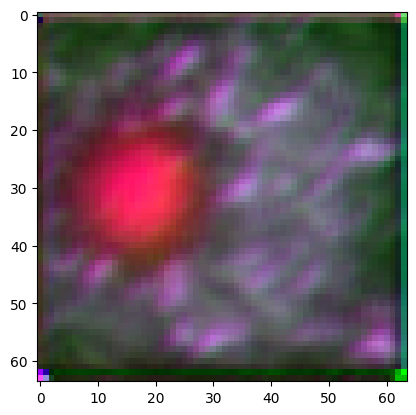

In [75]:
for i in range(5):
  random_latent_vectors = tf.random.normal(shape=(1, *noise_shape, 3))
  generated_images = np.squeeze(g_model(random_latent_vectors, training=False))

  plt.imshow(generated_images)